In [1]:
from openai.types.audio import TranscriptionVerbose, TranscriptionWord
from typing import List, Dict, Optional, Tuple, Union
from dataclasses import dataclass
import pandas as pd
from Levenshtein import distance
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from align import AlignedWord, deserialize_transcription_from_file, convert_file_times_to_absolute_times, word_similarity
import copy

In [2]:
def plot_length_ratios(lines_de, lines_en):
    length_ratios = [len(de) / len(en) for de, en in zip(lines_de, lines_en)]
    # print a chart of length_ratios

    # Plot the length ratios
    plt.figure(figsize=(10, 5))
    plt.plot(length_ratios)
    plt.title('Length Ratios of German and English Lines')
    plt.xlabel('Line Number')
    plt.ylabel('Length Ratio')
    plt.grid(True)
    plt.show()

    # Find the index where the length ratios start to deviate significantly
    threshold = 1.5  # Adjust this threshold as needed
    deviation_index = next((i for i, ratio in enumerate(length_ratios) if abs(ratio - 1) > threshold), None)

    if deviation_index is not None:
        print(f"Significant deviation starts at line {deviation_index}")
        print(f"German line: {lines_de[deviation_index]}")
        print(f"English line: {lines_en[deviation_index]}")
    else:
        print("No significant deviation found.")

def pair_libretto_lines_simple(german_text, english_text, character_names):
    lines_de = german_text.split("\n\n")
    lines_en = english_text.split("\n\n")

    # Remove empty lines
    lines_de = [line for line in lines_de if line.strip()]
    lines_en = [line for line in lines_en if line.strip()]

    print(len(lines_de), len(lines_en))

    # print the average length of each german line
    print(sum(len(line) for line in lines_de) / len(lines_de))
    print(sum(len(line) for line in lines_en) / len(lines_en))

    print(len(lines_de), len(lines_en))

    plot_length_ratios(lines_de, lines_en)

    return list(zip(lines_de, lines_en))

393 393
205.40458015267177
206.27735368956743
393 393


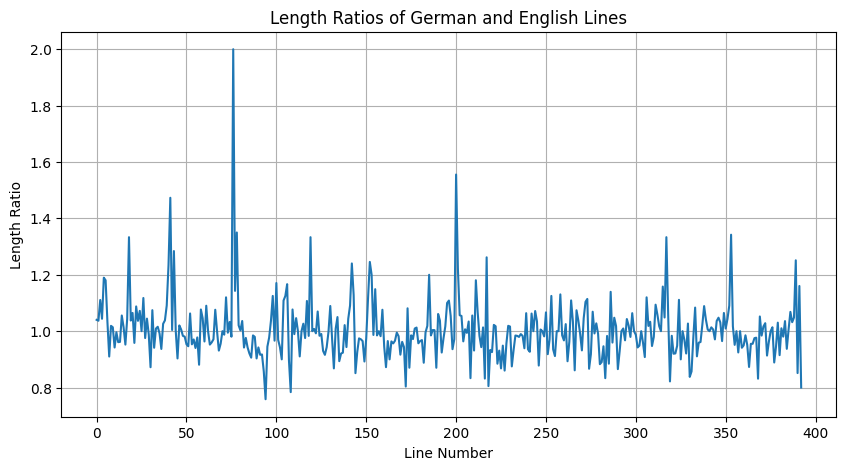

No significant deviation found.


In [3]:
with open("libretti/walkure_de.txt", "r", encoding="utf-8") as f:
    libretto_de = f.read()

with open("libretti/walkure_en.txt", "r", encoding="utf-8") as f:
    libretto_en = f.read()

characters = [
    "Rheintöchter",
    "Wotan",
    "Woglinde",
    "Wellgunde",
    "Flosshilde",
    "Alberich",
    "Fricka",
    "Freia",
    "Fasolt",
    "Fafner",
    "Froh",
    "Donner",
    "Loge",
    "Mime",
    "Erda",
    "Siegmund",
    "Sieglinde",
    "Hunding",
    "Brünnhilde",
]

pairs = pair_libretto_lines_simple(libretto_de, libretto_en, characters)

Splitting pair 0
Splitting pair 14
Splitting pair 26
Splitting pair 32
Splitting pair 37
Splitting pair 41
Splitting pair 44
Splitting pair 45
Splitting pair 50
Splitting pair 53
Splitting pair 59
Splitting pair 61
Splitting pair 65
Splitting pair 66
Splitting pair 68
Splitting pair 88
Splitting pair 96
Splitting pair 97
Splitting pair 109
Splitting pair 120
Splitting pair 142
Splitting pair 146
Splitting pair 147
Splitting pair 149
Splitting pair 152
Splitting pair 153
Splitting pair 155
Splitting pair 160
Splitting pair 161
Splitting pair 168
Splitting pair 176
Splitting pair 181
Splitting pair 210
Splitting pair 216
Splitting pair 218
Splitting pair 222
Splitting pair 346
Splitting pair 369
Splitting pair 373
Splitting pair 389
Splitting pair 394
Splitting pair 405
Splitting pair 407
Splitting pair 424
Splitting pair 426
Splitting pair 44
Splitting pair 147
Splitting pair 154
Splitting pair 163
Final number of pairs: 442
First pair: ('(Der Vorhang geht auf.)\n(Das Innere eines Wohnr

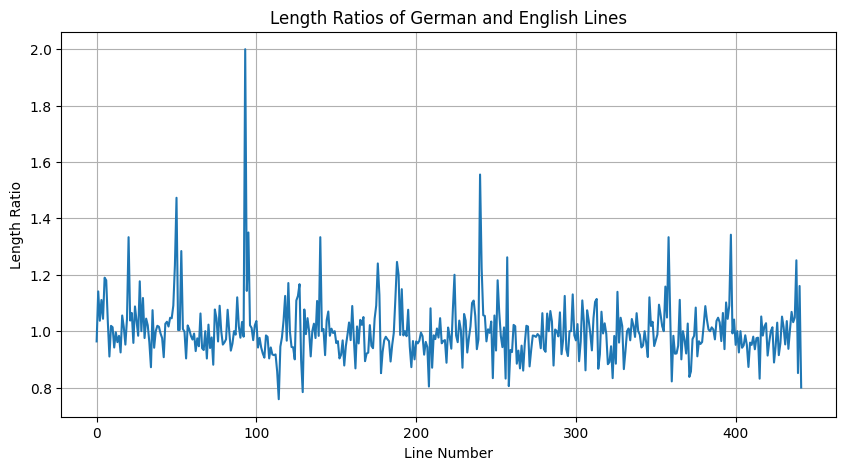

No significant deviation found.


In [4]:
def is_safe_split_point(lines, index):
    """Check if splitting at this line index would break any parentheses pairs"""
    text_before = '\n'.join(lines[:index])
    open_count = text_before.count('(') - text_before.count(')')
    return open_count == 0

def find_safe_split_point(lines):
    """Find the closest safe split point to the middle"""
    mid = len(lines) // 2
    
    # Try points progressively further from the middle
    for offset in range(len(lines)):
        # Try point after middle
        if mid + offset < len(lines):
            if is_safe_split_point(lines, mid + offset):
                return mid + offset
        # Try point before middle
        if mid - offset >= 1:  # Ensure we don't split at 0
            if is_safe_split_point(lines, mid - offset):
                return mid - offset
    
    # If no safe point found, return middle as fallback
    return mid

def split_long_pairs(pairs, max_length=15):
    need_another_pass = True
    while need_another_pass:
        need_another_pass = False
        i = 0
        while i < len(pairs):
            de, en = pairs[i]
            de_lines = de.split("\n")
            en_lines = en.split("\n")
            
            if len(de_lines) > max_length:
                need_another_pass = True
                print(f"Splitting pair {i}")
                
                # Find safe split point based on German text
                split_point = find_safe_split_point(de_lines)
                
                # Split both German and English at this point
                pairs[i] = (
                    "\n".join(de_lines[:split_point]),
                    "\n".join(en_lines[:split_point])
                )
                pairs.insert(i+1, (
                    "\n".join(de_lines[split_point:]),
                    "\n".join(en_lines[split_point:])
                ))
            i += 1

    return pairs

# Apply the splitting
pairs = split_long_pairs(pairs)

# print the number of pairs
print(f"Final number of pairs: {len(pairs)}")

# print the first pair
print("First pair:", pairs[0])

# print the last pair
print("Last pair:", pairs[-1])

plot_length_ratios([pair[0] for pair in pairs], [pair[1] for pair in pairs])

In [ ]:
for de, en in pairs:
    print("DE:", de)
    print("EN:", en)
    print("---")

In [6]:
def align_transcription_with_libretto(
    transcription: List[TranscriptionWord],
    libretto: List[str],
    min_similarity: float = 0.5
) -> List[AlignedWord]:
    """
    Align transcription with libretto using dynamic programming.
    Returns list of aligned words with timing information where available.
    
    Args:
        transcription: List of TranscriptionWord objects
        libretto: List of ground truth words
        min_similarity: Minimum similarity score to consider words as matching
    """
    
    # Initialize scoring matrix
    m, n = len(transcription), len(libretto)
    score_matrix = [[0.0] * (n + 1) for _ in range(m + 1)]
    backtrack = [[None] * (n + 1) for _ in range(m + 1)]
    
    # Gap penalties
    gap_penalty = -0.5
    
    # Fill scoring matrix
    for i in range(m + 1):
        score_matrix[i][0] = i * gap_penalty
    for j in range(n + 1):
        score_matrix[0][j] = j * gap_penalty
        
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            match_score = score_matrix[i-1][j-1] + similarity
            
            delete_score = score_matrix[i-1][j] + gap_penalty
            insert_score = score_matrix[i][j-1] + gap_penalty
            
            best_score = max(match_score, delete_score, insert_score)
            score_matrix[i][j] = best_score
            
            # Track the move that led to this cell
            if best_score == match_score:
                backtrack[i][j] = 'match'
            elif best_score == delete_score:
                backtrack[i][j] = 'delete'
            else:
                backtrack[i][j] = 'insert'
    
    # Backtrack to build alignment
    aligned_words: List[AlignedWord] = []
    i, j = m, n
    
    while i > 0 or j > 0:
        if i > 0 and j > 0 and backtrack[i][j] == 'match':
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            if similarity >= min_similarity:
                # Good match - use transcription timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=transcription[i-1].start,
                    end=transcription[i-1].end
                ))
            else:
                # Poor match - include word without timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=None,
                    end=None
                ))
            i -= 1
            j -= 1
        elif i > 0 and (j == 0 or backtrack[i][j] == 'delete'):
            # Skip transcription word
            i -= 1
        else:
            # Insert libretto word without timing
            aligned_words.append(AlignedWord(
                word=libretto[j-1],
                start=None,
                end=None
            ))
            j -= 1
    
    return list(reversed(aligned_words))

In [7]:
# Load transcriptions
transcriptions: List[TranscriptionVerbose] = []
for i in range(28, 71):
    i_string = str(i).zfill(3)
    transcription = deserialize_transcription_from_file(f'transcribed/{i_string}.json')
    transcriptions.append(transcription)

transcriptions = convert_file_times_to_absolute_times(transcriptions)

all_words: List[TranscriptionWord] = [word for transcription in transcriptions for word in transcription.words]

# Load libretto
with open('libretti/walkure_de.txt', 'r') as f:
    libretto = f.read()

libretto = libretto.split()

# Align texts
aligned_words = align_transcription_with_libretto(all_words, libretto, min_similarity=0.3)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words if word.start is not None and word.end is not None]) / len(aligned_words)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.559696394686907


In [8]:
def interpolate_word_timings(
    aligned_words: List[AlignedWord],
    max_interpolation_window: float = 8.0
) -> List[AlignedWord]:
    """
    Interpolate timing for words between known timestamps within a maximum window.
    
    Args:
        aligned_words: List of AlignedWord objects
        max_interpolation_window: Maximum time window in seconds for interpolation
        
    Returns:
        New list of AlignedWord objects with interpolated timings
    """
    result = copy.deepcopy(aligned_words)
    
    # First pass: identify sequences of words to interpolate
    sequences = []
    current_sequence = []
    last_known_end = None
    
    for i, word in enumerate(result):
        if word.start is not None and word.end is not None:
            # Found a word with known timing
            if current_sequence and last_known_end is not None:
                # Check if this word is within the interpolation window
                if word.start - last_known_end <= max_interpolation_window:
                    # Add the current word as the end anchor of the sequence
                    current_sequence.append(i)
                    sequences.append(current_sequence)
                current_sequence = []
            last_known_end = word.end
            current_sequence = [i]  # Start new sequence with this word
        elif current_sequence:
            # Add word without timing to current sequence
            current_sequence.append(i)
    
    # Second pass: perform interpolation for each valid sequence
    for sequence in sequences:
        if len(sequence) < 2:
            continue
        
        start_idx = sequence[0]
        end_idx = sequence[-1]
        start_word = result[start_idx]
        end_word = result[end_idx]
        
        # Skip if either anchor point doesn't have timing
        if (start_word.start is None or start_word.end is None or 
            end_word.start is None or end_word.end is None):
            continue
        
        # Calculate time distribution
        total_words = len(sequence)
        if total_words <= 1:
            continue
            
        # For the first word in sequence, keep its original end time
        # For the last word in sequence, keep its original start time
        total_time = end_word.start - start_word.end
        words_to_interpolate = total_words - 1  # excluding first word
        
        if words_to_interpolate <= 0:
            continue
            
        # Calculate time per word
        time_per_word = total_time / words_to_interpolate
        
        # Set timings for words in between
        current_time = start_word.end
        for i in range(1, len(sequence)):
            idx = sequence[i]
            word = result[idx]
            
            if i == len(sequence) - 1:
                # Last word in sequence - keep its original timing
                word.start = end_word.start
                word.end = end_word.end
            else:
                # Interpolated word
                word.start = current_time
                word.end = current_time + time_per_word
                current_time += time_per_word
    
    return result

In [9]:
aligned_words = interpolate_word_timings(aligned_words, max_interpolation_window=20)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words if word.start is not None and word.end is not None]) / len(aligned_words)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.9331309297912713


In [10]:
# write aligned words to csv

def write_aligned_words_to_csv(aligned_words: List[AlignedWord], filename: str):
    # Convert list of AlignedWord to list of dictionaries
    data = [{'word': w.word, 'start': w.start, 'end': w.end} for w in aligned_words]
    
    # Create DataFrame and write to CSV
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def read_edited_aligned_words_from_csv(filename: str) -> List[AlignedWord]:
    # Read CSV into DataFrame
    df = pd.read_csv(filename)

    # Convert DataFrame to list of AlignedWord
    aligned_words = [AlignedWord(row['word'], row['start'], row['end']) for _, row in df.iterrows()]

    # replace nans with None
    for word in aligned_words:
        if pd.isna(word.start):
            word.start = None
        if pd.isna(word.end):
            word.end = None

    return aligned_words

write_aligned_words_to_csv(aligned_words, 'aligned_words_walkure.csv')

# read aligned words from csv
aligned_words = read_edited_aligned_words_from_csv('aligned_words_walkure.csv')

In [ ]:
from moviepy.editor import (
    AudioFileClip, TextClip, CompositeVideoClip, 
    ColorClip, concatenate_audioclips, VideoClip
)
from typing import List, Tuple, Optional, Dict
import numpy as np
import imageio
from tqdm import tqdm

def split_text_for_formatting(text: str, character_names: List[str]) -> List[Tuple[str, str]]:
    """Split text into segments with formatting.
    Returns list of (text, format_type) tuples.
    format_type can be 'regular', 'italic', or 'bold'"""
    segments = []
    current_pos = 0
    
    # First check if the line starts with a character name
    for name in character_names:
        if text.startswith(name + "\n"):
            name_end = len(name) + 1 # Include the period/colon and space
            segments.append((text[:name_end], 'bold'))
            current_pos = name_end
            break
    
    while True:
        # Find next opening parenthesis
        start = text.find('(', current_pos)
        if start == -1:
            # Add remaining text as regular if any
            if current_pos < len(text):
                segments.append((text[current_pos:], 'regular'))
            break
            
        # Add text before parentheses as regular
        if start > current_pos:
            segments.append((text[current_pos:start], 'regular'))
            
        # Find closing parenthesis
        end = text.find(')', start)
        if end == -1:  # No closing parenthesis
            segments.append((text[start:], 'regular'))
            break
            
        # Add parenthetical text as italic (including parentheses)
        segments.append((text[start:end+1], 'italic'))
        current_pos = end + 1
        
    return segments

def create_title_clip(
    video_width: int,
    video_height: int,
    font_name: str,
    font_size: int = 60,
    color: str = 'white',
) -> np.ndarray:
    """Creates a title frame for the video."""
    # Create background
    background = ColorClip(size=(video_width, video_height), color=(0, 0, 0))
    
    # Create title text
    title_text = TextClip(
        "DIE WALKÜRE",
        font=f"{font_name}-Bold",
        fontsize=font_size,
        color=color,
        size=(video_width // 2 - 80, None),
        method='caption',
        align='center'
    )
    
    # Position clips side by side
    composed = CompositeVideoClip([
        background,
        title_text.set_position((40, video_height // 2 - title_text.h // 2)),
        title_text.set_position((video_width//2 + 40, video_height // 2 - title_text.h // 2))
    ])
    
    frame = composed.get_frame(0)
    
    # Clean up
    background.close()
    title_text.close()
    composed.close()
    
    return frame

def create_formatted_text(
    text: str, 
    color: str, 
    column_width: int, 
    max_height: int, 
    font_name: str,
    font_size: int,
    character_names: List[str]
) -> TextClip:
    """Creates a composite clip of regular, italic, and bold text segments with height constraints."""
    segments = split_text_for_formatting(text, character_names)
    clips = []
    y_position = 0
    current_font_size = font_size
    
    while True:
        clips = []
        y_position = 0
        
        for segment_text, format_type in segments:
            font = font_name
            if format_type == 'italic':
                font = f"{font_name}-Italic"
            elif format_type == 'bold':
                font = f"{font_name}-Bold"
                
            clip = TextClip(
                segment_text,
                font=font,
                fontsize=current_font_size,
                color=color,
                size=(column_width, None),
                method='caption',
                align='center'
            )
            clips.append(clip.set_position((0, y_position)))
            y_position += clip.h
            
        # Check if total height exceeds maximum allowed height
        if y_position <= max_height or current_font_size <= 20:  # Set minimum font size
            break
            
        # If too tall, reduce font size and try again
        current_font_size -= 2
        for clip in clips:
            clip.close()
    
    if not clips:
        return None
        
    composite = CompositeVideoClip(
        clips, 
        size=(column_width, y_position)
    )
    
    for clip in clips:
        clip.close()
        
    return composite

def create_parallel_text_video(
    aligned_words: List[AlignedWord],
    line_pairs: List[Tuple[str, str]],
    character_names: List[str],
    output_filename: str = "parallel_text.mp4",
    font_name: str = "Arial",
    font_size: int = 40,
    video_width: int = 1920,
    video_height: int = 1080,
    fps: int = 24,
    text_timeout: float = 5.0,
):
    # Audio handling
    audio_files = [f"ring/{str(i).zfill(3)}.wav" for i in range(28, 71)]
    audio_clips = [AudioFileClip(f) for f in audio_files]
    combined_audio = concatenate_audioclips(audio_clips)
    total_duration = sum(clip.duration for clip in audio_clips)
    
    # Create background
    background = ColorClip(size=(video_width, video_height), color=(0, 0, 0))
    background = background.set_duration(total_duration)
    
    # Create word-to-line mapping
    word_to_line_idx = {}
    current_word_idx = 0
    for line_idx, (sung_line, _) in enumerate(line_pairs):
        words_in_line = sung_line.split()
        for _ in words_in_line:
            if current_word_idx < len(aligned_words):
                word_to_line_idx[current_word_idx] = line_idx
                current_word_idx += 1

    # Pre-compute text clips for each line pair
    line_pair_clips = {}
    column_width = (video_width // 2) - 80  # Leave margins
    vertical_margin = 80  # Adjust this value as needed
    max_text_height = video_height - (2 * vertical_margin)

    print("Pre-computing text clips...")
    for idx, (sung_text, translated_text) in tqdm(enumerate(line_pairs), total=len(line_pairs)):
        # Create formatted text clips with height constraint
        left_text = create_formatted_text(
            sung_text, 'AliceBlue', column_width, max_text_height, 
            font_name, font_size, character_names
        )
        right_text = create_formatted_text(
            translated_text, 'LightGoldenrod', column_width, max_text_height,
            font_name, font_size, character_names
        )
        
        if left_text is None or right_text is None:
            continue
            
        # Calculate vertical centering with margins
        max_height = max(left_text.h, right_text.h)
        y_position = vertical_margin + (max_text_height - max_height) // 2
        
        # Position clips side by side
        composed = CompositeVideoClip([
            background,
            left_text.set_position((40, y_position)),
            right_text.set_position((video_width//2 + 40, y_position))
        ])
        
        line_pair_clips[idx] = composed.get_frame(0)
        
        # Clean up
        left_text.close()
        right_text.close()
        composed.close()

        # write frame to local image file
        with open(f'images2/frame_{idx}.png', 'wb') as f:
            f.write(imageio.imwrite('<bytes>', line_pair_clips[idx], format='png'))

    line_pair_clips[-1] = create_title_clip(
        video_width, video_height, font_name, font_size + 20, 'LightGoldenrod'
    ) 

    def get_active_line_idx(time: float) -> Optional[int]:
        """Determine which line is currently active based on word timings."""
        if time < 10:
            return -1
        
        # Check for active words
        for word_idx, word in enumerate(aligned_words):
            if word.start is not None and word.end is not None:
                if word.start <= time <= word.end:
                    return word_to_line_idx.get(word_idx)
        
        # If no active word, check for recent words
        last_active_time = -float('inf')
        last_active_idx = None
        
        for word_idx, word in enumerate(aligned_words):
            if word.end is not None and word.end <= time:
                if word.end > last_active_time:
                    last_active_time = word.end
                    last_active_idx = word_idx
        
        if last_active_idx is not None and time - last_active_time <= text_timeout:
            return word_to_line_idx.get(last_active_idx)
        
        return None

    def make_frame(t: float):
        active_line_idx = get_active_line_idx(t)
        return line_pair_clips.get(active_line_idx, background.get_frame(0))

    # Create and write video
    video = VideoClip(make_frame, duration=total_duration).set_fps(fps)
    final_video = video.set_audio(combined_audio)
    
    final_video.write_videofile(
        output_filename,
        fps=fps,
        codec='libx264',
        audio_codec='aac'
    )
    
    # Clean up
    combined_audio.close()
    for clip in audio_clips:
        clip.close()
    video.close()
    final_video.close()

In [ ]:
characters = [
    "Rheintöchter",
    "Wotan",
    "Woglinde",
    "Wellgunde",
    "Flosshilde",
    "Alberich",
    "Fricka",
    "Freia",
    "Fasolt",
    "Fafner",
    "Froh",
    "Donner",
    "Loge",
    "Mime",
    "Erda",
    "Siegmund",
    "Sieglinde",
    "Hunding",
    "Brünnhilde",
    "Gerhilde",
    "Ortlinde",
    "Waltraute",
    "Schwertleite",
    "Helmwige",
    "Siegrune",
    "Grimgerde",
    "Rossweisse",
]

create_parallel_text_video(
    aligned_words=aligned_words,
    line_pairs=pairs,
    character_names=characters,
    output_filename='walkure_caption.mp4',
    font_name="Baskerville",
    video_width=1920,
    video_height=1080,
    font_size=40,
    text_timeout=30,
    fps=4
)

Pre-computing text clips...


100%|██████████| 442/442 [04:59<00:00,  1.48it/s]


Moviepy - Building video walkure_caption.mp4.
MoviePy - Writing audio in walkure_captionTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video walkure_caption.mp4



Moviepy - Done !
Moviepy - video ready walkure_caption.mp4


In [27]:
for i in TextClip.list('font'):
    if 'Baskerville' in i:
        print(i)

Baskerville
Baskerville-Bold
Baskerville-Bold-Italic
Baskerville-Italic
Baskerville-SemiBold
Baskerville-SemiBold-Italic


In [43]:
TextClip.list('color')

[b'',
 b'Name',
 b'-------------------------------------------------------------------------------',
 b'AliceBlue',
 b'AntiqueWhite',
 b'AntiqueWhite1',
 b'AntiqueWhite2',
 b'AntiqueWhite3',
 b'AntiqueWhite4',
 b'aqua',
 b'aquamarine',
 b'aquamarine1',
 b'aquamarine2',
 b'aquamarine3',
 b'aquamarine4',
 b'azure',
 b'azure1',
 b'azure2',
 b'azure3',
 b'azure4',
 b'beige',
 b'bisque',
 b'bisque1',
 b'bisque2',
 b'bisque3',
 b'bisque4',
 b'black',
 b'BlanchedAlmond',
 b'blue',
 b'blue1',
 b'blue2',
 b'blue3',
 b'blue4',
 b'BlueViolet',
 b'brown',
 b'brown1',
 b'brown2',
 b'brown3',
 b'brown4',
 b'burlywood',
 b'burlywood1',
 b'burlywood2',
 b'burlywood3',
 b'burlywood4',
 b'CadetBlue',
 b'CadetBlue1',
 b'CadetBlue2',
 b'CadetBlue3',
 b'CadetBlue4',
 b'chartreuse',
 b'chartreuse1',
 b'chartreuse2',
 b'chartreuse3',
 b'chartreuse4',
 b'chocolate',
 b'chocolate1',
 b'chocolate2',
 b'chocolate3',
 b'chocolate4',
 b'coral',
 b'coral1',
 b'coral2',
 b'coral3',
 b'coral4',
 b'CornflowerBlue',
 b